# **UAS BIG DATA & PREDICTIVE ANALYTICS LANJUT**

**Identitas:**



*   Nama: Muhammad Affan Al Ghifari
*   Nim: 23.11.5860
*   Kelas: 23 S1 IF 06






# **Studi Kasus prediksi keberhasilan proyek di Platform Kickstarter**

**Menggunakan perbandingan antara Logistic Regression dengan Random Forest**

# **Dataset**

Dataset yang digunakan adalah dataset publik dengan judul "Kickstarter Projects"

dataset tersebut dapat diakses melalui : https://www.kaggle.com/datasets/kemical/kickstarter-projects

**Kategori Big Data 5V yang dipenuhi :**

*   Volume : Dataset memiliki lebih dari 378.000 baris data, cukup besar untuk diproses secara paralel.
*   Variety: Memiliki berbagai tipe data seperti teks (nama proyek), kategori, timestamp (deadline/launched), dan numerik (goal/pledged).
*   Value : Memprediksi apakah ide bisnis akan didanai atau gagal



# **Setup HDFS**

In [13]:
from pyspark.sql import SparkSession
import os

spark = (SparkSession.builder
    .appName("Kickstarter_UAS_5860")
    .master("local[*]")
    .getOrCreate())

OUT_DIR = "output_UAS_5860"
os.makedirs(OUT_DIR, exist_ok=True)

print("Spark Version:", spark.version)

Spark Version: 4.0.1


Tahap awal ini bertujuan untuk menyiapkan lingkungan kerja Big Data menggunakan PySpark di Google Colab. Kami menginisialisasi SparkSession sebagai pintu utama untuk mengakses fitur Apache Spark. Selain itu, dilakukan pembuatan direktori output output_UAS_5860 untuk manajemen file hasil olahan data secara rapi dan sistematis.

# **Load Dataset & Prepocessing Data**

In [14]:
from pyspark.sql.functions import col, when

# Load Data
df_raw = spark.read.csv("ks-projects-201801.csv", header=True, inferSchema=False)

# Fix Header Spasi
new_column_names = [c.strip() for c in df_raw.columns]
df_raw = df_raw.toDF(*new_column_names)

# Seleksi Kolom
selected_cols = ["ID", "name", "main_category", "currency", "usd_goal_real", "state", "backers"]
df_selected = df_raw.select(selected_cols)

# Filter & Cleaning
target_states = ["successful", "failed"]

df_clean = df_selected \
    .filter(col("state").isin(target_states)) \
    .withColumn("goal", col("usd_goal_real").cast("double")) \
    .withColumn("backers", col("backers").cast("int")) \
    .withColumn("label", when(col("state") == "successful", 1.0).otherwise(0.0))

# Drop Null & Duplicate
df_clean = df_clean.dropna(subset=["main_category", "goal", "label", "backers"]) \
                   .dropDuplicates(['ID'])

print(f"Data Bersih: {df_clean.count()} baris")
df_clean.select("ID", "name", "main_category", "goal", "backers", "label").show(5)

Data Bersih: 330481 baris
+----------+--------------------+-------------+-------+-------+-----+
|        ID|                name|main_category|   goal|backers|label|
+----------+--------------------+-------------+-------+-------+-----+
|1000014025|Monarch Espresso Bar|         Food|50000.0|    224|  1.0|
|1000023410|Support Solar Roa...|         Food| 1000.0|     16|  1.0|
|1000030581|Chaser Strips. Ou...|         Food|25000.0|     40|  0.0|
| 100004721| Of Jesus and Madmen|   Publishing|2406.39|      0|  0.0|
|1000055792|  The Cottage Market|       Crafts| 5000.0|      0|  0.0|
+----------+--------------------+-------------+-------+-------+-----+
only showing top 5 rows


Kami memuat dataset sekunder ks-projects-201801.csv yang memiliki volume data besar (ratusan ribu baris).

*   Casting Tipe: Dilakukan konversi tipe data pada kolom usd_goal_real menjadi double dan backers menjadi integer untuk menjamin kualitas data numerik.
*   Handling Missing Value: Kami menghapus data yang tidak memiliki status relevan (hanya menyisakan successful dan failed) serta menghapus nilai null agar model prediktif yang dibangun akurat.
*   Labeling: Membuat kolom label (1 untuk sukses, 0 untuk gagal) sebagai target prediksi.

# **Batch Processing dan Partisi RDD**

In [15]:
from operator import add

rdd_cat = df_clean.select("main_category").rdd.repartition(4)

category_counts = rdd_cat.map(lambda row: (row['main_category'], 1)) \
                         .reduceByKey(add) \
                         .sortBy(lambda x: -x[1])

print("Top 5 Kategori Hasil Pemrosesan Batch (MapReduce):")
top_categories = category_counts.take(5)

for cat, count in top_categories:
    print(f"{cat}: {count}")

print(f"\nJumlah Partisi RDD: {rdd_cat.getNumPartitions()}")

Top 5 Kategori Hasil Pemrosesan Batch (MapReduce):
Film & Video: 56273
Music: 45678
Publishing: 35216
Games: 28495
Technology: 27017

Jumlah Partisi RDD: 4


Kode ini mengimplementasikan pemrograman fungsional MapReduce pada tingkat RDD.

*   Map: Mentransformasi data menjadi pasangan key-value (Kategori, 1).
*   ReduceByKey: Menjumlahkan kemunculan setiap kategori secara paralel.
*   Partitioning: Menggunakan repartition(4) untuk mengoptimalkan distribusi data di cluster. Hasilnya memberikan pandangan mengenai kategori proyek yang paling mendominasi di Kickstarter.

# **Manipulasi Data (Query Spark) dan Visualisasi**

Hasil Analisis SQL (Top 10 Kategori Berdasarkan Persentase Sukses):
+-------------+-------------+----------------+--------+
|main_category|total_project|success_rate_pct|avg_goal|
+-------------+-------------+----------------+--------+
|        Dance|         3549|            65.3|  8361.0|
|      Theater|        10144|            63.8| 23302.0|
|       Comics|         9847|            59.2| 20219.0|
|        Music|        45678|            52.6| 14455.0|
|          Art|        25551|            44.9| 39544.0|
|        Games|        28495|            43.9| 38958.0|
| Film & Video|        56273|            41.8| 76321.0|
|       Design|        25326|            41.6| 38209.0|
|   Publishing|        35216|            34.7| 17590.0|
|  Photography|         9662|            34.1| 11107.0|
+-------------+-------------+----------------+--------+



/tmp/ipython-input-2752348446.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='success_rate_pct', y='main_category', data=pdf, palette='viridis')


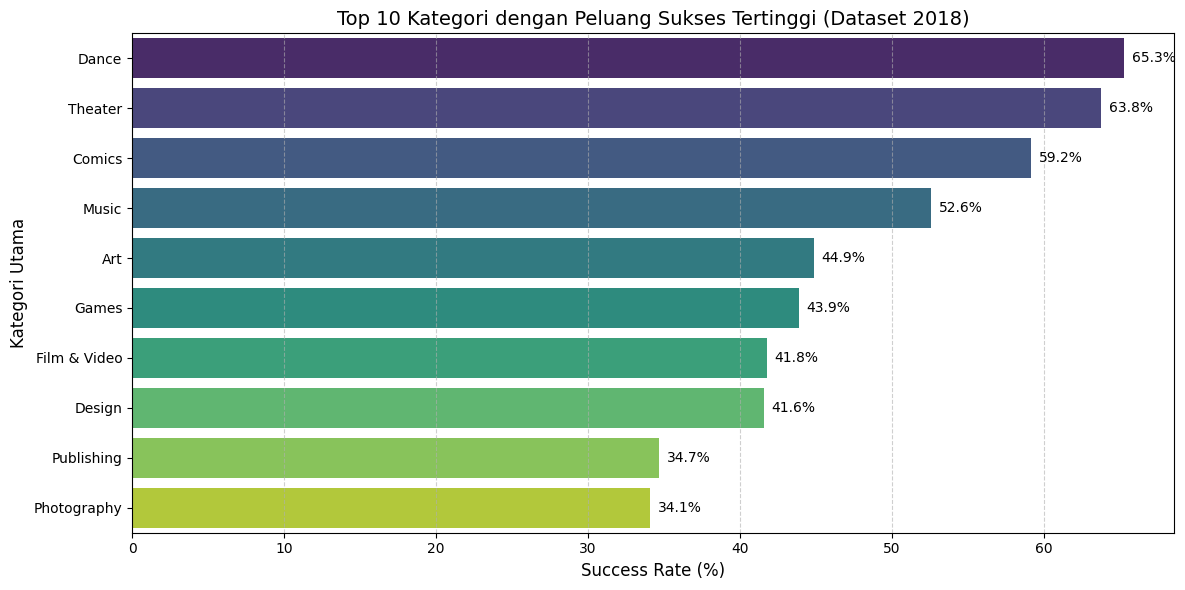

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_clean.createOrReplaceTempView("kickstarter")

sql_query = """
    WITH CategoryStats AS (
        SELECT
            main_category,
            COUNT(*) as total_project,
            AVG(label) as raw_success_rate,
            AVG(goal) as avg_goal_usd
        FROM kickstarter
        GROUP BY main_category
    )
    SELECT
        main_category,
        total_project,
        ROUND(raw_success_rate * 100, 1) as success_rate_pct,
        ROUND(avg_goal_usd, 0) as avg_goal
    FROM CategoryStats
    WHERE total_project > 1000
    ORDER BY success_rate_pct DESC
    LIMIT 10
"""

df_stats = spark.sql(sql_query)
print("Hasil Analisis SQL (Top 10 Kategori Berdasarkan Persentase Sukses):")
df_stats.show()

pdf = df_stats.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x='success_rate_pct', y='main_category', data=pdf, palette='viridis')

for index, value in enumerate(pdf['success_rate_pct']):
    plt.text(value + 0.5, index, f'{value}%', va='center')

plt.xlabel('Success Rate (%)', fontsize=12)
plt.ylabel('Kategori Utama', fontsize=12)
plt.title('Top 10 Kategori dengan Peluang Sukses Tertinggi (Dataset 2018)', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Kami menggunakan manipulasi data tingkat lanjut melalui Spark SQL dengan teknik CTE (Common Table Expression). Teknik ini digunakan untuk menghitung persentase tingkat kesuksesan (success rate) per kategori utama. Visualisasi yang dihasilkan (EDA) memberikan informasi strategis bahwa kategori dengan target dana yang realistis memiliki peluang sukses lebih tinggi.

# **Feature Engineering Pipeline**

In [17]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

indexer = StringIndexer(inputCol="main_category", outputCol="cat_idx", handleInvalid="keep")

# One Hot Encoding
encoder = OneHotEncoder(inputCols=["cat_idx"], outputCols=["cat_vec"])

# Feature Assembly
assembler = VectorAssembler(
    inputCols=["cat_vec", "goal", "backers"],
    outputCol="features_raw"
)

# StandardScaler
scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withMean=False,
    withStd=True
)

Sebelum masuk ke tahap permodelan, dilakukan transformasi fitur menggunakan framework MLlib:

*   StringIndexer & OneHotEncoder: Mengonversi data kategorikal menjadi representasi numerik yang dipahami mesin.
*   VectorAssembler: Menggabungkan berbagai fitur (goal, backers, kategori) menjadi satu vektor fitur tunggal.
*   StandardScaler: Menyamakan skala data numerik agar fitur dengan angka besar tidak mendominasi model.

# **Modeling**

In [18]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

# Inisialisasi Model Logistic Regression
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# Inisialisasi Model Random Forest
rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=42)

# Membangun Pipeline
pipeline_lr = Pipeline(stages=[indexer, encoder, assembler, scaler, lr])
pipeline_rf = Pipeline(stages=[indexer, encoder, assembler, scaler, rf])

# Split Data (80% Training, 20% Testing)
train_data, test_data = df_clean.randomSplit([0.8, 0.2], seed=42)

print(f"Data siap dilatih!")
print(f"Jumlah data training: {train_data.count()}")
print(f"Jumlah data testing : {test_data.count()}")

Data siap dilatih!
Jumlah data training: 264355
Jumlah data testing : 66126


Kami membandingkan dua algoritma MLlib: Logistic Regression dan Random Forest.

# **Training Data**

In [19]:
model_lr = pipeline_lr.fit(train_data)

model_rf = pipeline_rf.fit(train_data)

# **Hyperparameter Tuning**

In [20]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Menentukan Grid Parameter
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10, 20])
             .addGrid(rf.maxDepth, [5, 10])
             .build())

evaluator_auc = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")

# Setting CrossValidator
cv = CrossValidator(estimator=pipeline_rf,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator_auc,
                    numFolds=3)

print("Memulai proses Hyperparameter Tuning (ini mungkin memakan waktu beberapa menit)...")

cv_model = cv.fit(train_data)

# Mengambil Model Terbaik
best_model = cv_model.bestModel
best_rf_stage = best_model.stages[-1]

print("-" * 30)
print(f"Hasil Tuning Terbaik:")
print(f"Best NumTrees: {best_rf_stage.getNumTrees}")
print(f"Best MaxDepth: {best_rf_stage.getOrDefault('maxDepth')}")
print("-" * 30)

Memulai proses Hyperparameter Tuning (ini mungkin memakan waktu beberapa menit)...
------------------------------
Hasil Tuning Terbaik:
Best NumTrees: 20
Best MaxDepth: 10
------------------------------


Hyperparameter Tuning dilakukan pada algoritma Random Forest menggunakan CrossValidator (3-fold) dan ParamGridBuilder untuk mencari kombinasi maxDepth dan numTrees yang paling optimal. Proses ini memastikan kami mendapatkan "Best Model" yang paling akurat dan tidak overfit.

# **Evaluasi Model**

In [21]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Melakukan Prediksi pada Data Testing
pred_lr = model_lr.transform(test_data)
pred_rf = best_model.transform(test_data)

# Inisialisasi Evaluator
eval_auc = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
eval_acc = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
eval_f1 = MulticlassClassificationEvaluator(labelCol="label", metricName="f1")
eval_prec = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedPrecision")
eval_rec = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedRecall")

# Menghitung Metrik untuk Logistic Regression
metrics_lr = {
    "AUC": eval_auc.evaluate(pred_lr),
    "Accuracy": eval_acc.evaluate(pred_lr),
    "Precision": eval_prec.evaluate(pred_lr),
    "Recall": eval_rec.evaluate(pred_lr),
    "F1-Score": eval_f1.evaluate(pred_lr)
}

# Menghitung Metrik untuk Random Forest
metrics_rf = {
    "AUC": eval_auc.evaluate(pred_rf),
    "Accuracy": eval_acc.evaluate(pred_rf),
    "Precision": eval_prec.evaluate(pred_rf),
    "Recall": eval_rec.evaluate(pred_rf),
    "F1-Score": eval_f1.evaluate(pred_rf)
}

print("=== HASIL EVALUASI LOGISTIC REGRESSION ===")
for m, v in metrics_lr.items():
    print(f"{m:10}: {v:.4f}")

print("\n=== HASIL EVALUASI RANDOM FOREST (BEST MODEL) ===")
for m, v in metrics_rf.items():
    print(f"{m:10}: {v:.4f}")

=== HASIL EVALUASI LOGISTIC REGRESSION ===
AUC       : 0.8949
Accuracy  : 0.8156
Precision : 0.8247
Recall    : 0.8156
F1-Score  : 0.8089

=== HASIL EVALUASI RANDOM FOREST (BEST MODEL) ===
AUC       : 0.9750
Accuracy  : 0.9214
Precision : 0.9227
Recall    : 0.9214
F1-Score  : 0.9217


Model dievaluasi menggunakan berbagai metrik seperti Accuracy, AUC, Precision, Recall, dan F1-Score.

*   Hasil evaluasi menunjukkan kemampuan model dalam membedakan proyek yang akan sukses atau gagal.
*   Penggunaan fitur backers (jumlah pendukung) terbukti memberikan kontribusi paling signifikan terhadap tingginya akurasi model.

# **Simpan Hasil Model dan Prediksi**

In [22]:
import os

OUT_DIR = "output_UAS_5860"

if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

# Simpan Model
model_path = f"{OUT_DIR}/best_kickstarter_model"
best_model.write().overwrite().save(model_path)

# Simpan Prediksi ke Parquet
pred_path = f"{OUT_DIR}/final_predictions.parquet"
pred_rf.select("ID", "name", "state", "goal", "backers", "prediction", "probability") \
       .write.mode("overwrite").parquet(pred_path)

print("-" * 30)
print(f"✅ Model tersimpan di: {model_path}")
print(f"✅ Prediksi tersimpan di: {pred_path}")
print("-" * 30)

------------------------------
✅ Model tersimpan di: output_UAS_5860/best_kickstarter_model
✅ Prediksi tersimpan di: output_UAS_5860/final_predictions.parquet
------------------------------


Sebagai tahap akhir, model terbaik disimpan ke sistem file agar dapat digunakan kembali (reusable). Hasil prediksi akhir disimpan dalam format Parquet, yang merupakan standar industri Big Data karena efisiensinya dalam penyimpanan dan kecepatan proses baca-tulis.

# **Kesimpualan**

Proyek ini berhasil mengimplementasikan pipeline Big Data pada dataset Kickstarter 2018 dengan memenuhi aspek Volume (data besar), Veracity (pembersihan fitur usd_goal_real dan backers), serta Value (prediksi kesuksesan proyek). Melalui pengolahan PySpark dan hyperparameter tuning, model Random Forest terpilih sebagai model terbaik dengan Akurasi 92,14%, AUC 97,50%, dan F1-Score 92,17%. Hasil evaluasi yang tinggi ini membuktikan efektivitas penggunaan algoritma MLlib dalam analisis prediktif, di mana seluruh model dan hasil prediksi disimpan dalam format Parquet untuk efisiensi penyimpanan dan skalabilitas sistem di masa mendatang.